### 載入所需的Libraries

In [1]:
import re
import pandas as pd
import numpy as np

### 載入資料

In [2]:
# read data from spam.csv
sms_data = pd.read_csv('spam.csv',encoding='Latin')
sms_data = sms_data.iloc[:,:2]
sms_data.columns = ['label','content']
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check how many spams and hams
print(len(sms_data))
sms_data.groupby('label').count()

5572


,content
label,
ham,4825
spam,747


In [4]:
# change label to from string to number
# "ham" --> 0, "spam" --> 1
sms_data['label'].replace(['ham','spam'], [0,1], inplace=True)
sms_data.head()

,label,content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### 切分資料
將資料依據label比例切分為training data與testing data

In [5]:
from sklearn.model_selection import train_test_split

sms_train, sms_test = train_test_split(sms_data, test_size=0.2, stratify=sms_data.label)

print(sms_train.groupby("label").count())
print(sms_test.groupby("label").count())

       content
label         
0         3859
1          598
       content
label         
0          966
1          149


In [6]:
sms_train.head()

,label,content
312,0,He says he'll give me a call when his friend's...
5408,0,... Are you in the pub?
2604,0,You call times job today ok umma and ask them ...
5462,1,Txt: CALL to No: 86888 & claim your reward of ...
1517,1,Our brand new mobile music service is now live...


In [7]:
sms_test.head()

,label,content
2287,0,Alex knows a guy who sells mids but he's down ...
1208,0,Also maaaan are you missing out
4756,0,"hey, looks like I was wrong and one of the kap..."
3947,0,I like to think there's always the possibility...
3658,0,Wait.i will come out.. &lt;#&gt; min:)


### 資料預處理
* 將所有字詞轉為小寫
* 移除所有數字、標點符號

In [8]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    for i, row in df.iterrows():
        # make all content to lowercase
        # remove all punctuations
        text = " ".join([word for word in re.findall(r"[a-zA-Z]*", row['content'].lower()) if word != ""])
        df.at[i,'content'] = text
    
    return df

In [9]:
processed_train = preprocess(sms_train)
print("Train:")
print(processed_train.head())

Train:
      label                                            content
312       0  he says he ll give me a call when his friend s...
5408      0                                 are you in the pub
2604      0  you call times job today ok umma and ask them ...
5462      1  txt call to no claim your reward of hours talk...
1517      1  our brand new mobile music service is now live...


In [10]:
processed_test = preprocess(sms_test)
print("Test:")
print(processed_test.head())

Test:
      label                                            content
2287      0  alex knows a guy who sells mids but he s down ...
1208      0                    also maaaan are you missing out
4756      0  hey looks like i was wrong and one of the kapp...
3947      0  i like to think there s always the possibility...
3658      0                     wait i will come out lt gt min


In [11]:
# split data into x_train, y_train, x_test, y_test
y_train, x_train = zip(*processed_train.values)
y_test, x_test = zip(*processed_test.values)

# check numbers of unique word in the corpus
len(set(" ".join(list(x_train + x_test)).split()))

7708

### TF-IDF
可以發現種共有7708個字詞，這裡使用TF-IDF將來選取最高分的前2000個字詞
(若忘記的學員可參考先前TF-IDF課程章節或[此篇教學](https://ithelp.ithome.com.tw/articles/10228815?sc=iThelpR))

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000)
vectorizer.fit(x_train)

tfidf_train = vectorizer.transform(x_train)
tfidf_test = vectorizer.transform(x_test)

print(f"Number of unique word: {len(vectorizer.vocabulary_)}")
(tfidf_train, tfidf_test)

Number of unique word: 2000


(<4457x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 50733 stored elements in Compressed Sparse Row format>,
 <1115x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 12742 stored elements in Compressed Sparse Row format>)

### 建立共現矩陣

In [13]:
from typing import List

def create_co_matrix(corpus: List[str], vocab_list: List[str], word2idx: dict,
                     window_size: int=1, use_weighting: bool=False, verbose: bool=False) -> np.ndarray:
    '''Function to create co-occurrence matrix
    '''
    #initialize co-occurrence matrix
    vocab_size = len(vocab_list)
    co_matrix = np.zeros(shape=(vocab_size, vocab_size), dtype=np.int32)
    
    for idx, sms in enumerate(corpus):
        sms = sms.split()
        sms_ids = [word2idx[word] for word in sms if word in vocab_list]
        sms_len = len(sms_ids)
                
        for center_i, center_word_id in enumerate(sms_ids):
            for i in range(1, window_size+1):
                left_idx = center_i - i
                right_idx = center_i + i
                
                if left_idx >= 0:
                    left_word_id = sms_ids[left_idx]
                    co_matrix[center_word_id, left_word_id] += 1
                
                if right_idx < sms_len:
                    right_word_id = sms_ids[right_idx]
                    co_matrix[center_word_id, right_word_id] += 1
        
        if verbose:
            if idx != 0 and idx%500 == 0:
                print(f"finishing {idx+1}/{len(corpus)}")
    
    print("Done")
    
    if use_weighting:
        # if use weighting, then we set the co-occurrence with the word itself to 1.0
        np.fill_diagonal(co_matrix, 1.)
        
    return co_matrix

In [14]:
co_matrix = create_co_matrix(x_train, vectorizer.get_feature_names(), vectorizer.vocabulary_,
                            window_size=3, use_weighting=True, verbose=True)

co_matrix

finishing 501/4457
finishing 1001/4457
finishing 1501/4457
finishing 2001/4457
finishing 2501/4457
finishing 3001/4457
finishing 3501/4457
finishing 4001/4457
Done


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

### 建立PPMI矩陣

In [15]:
#定義正向點間互資訊

def ppmi(co_matrix: np.ndarray, eps: float=1e-8, verbose: bool=False):
    M = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    S = np.sum(co_matrix, axis=0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            pmi = np.log2(co_matrix[i, j]*N / (S[i]*S[j]))
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % 10 == 0 or cnt == total:
                    print(f"{cnt}/{total} Done")
    
    return M

In [16]:
ppmi_matrix = ppmi(co_matrix, verbose=False)
ppmi_matrix

C:\Users\angel\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log2
  # This is added back by InteractiveShellApp.init_path()


array([[10.280853 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  8.479924 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  4.6661434, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ..., 10.280853 ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  4.5848594,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         9.04751  ]], dtype=float32)

### 使用SVD降維
利用sklearn中的TruncatedSVD對co-occurrence matrix進行降維，並利用variance來找出最適合的維度
[參考文獻](https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d)

(讀者可以嘗試使用SVD對PPMI進行降維)

In [17]:
from sklearn.decomposition import TruncatedSVD

# Program to find the optimal number of components for Truncated SVD
n_comp = range(10,150,10) # list containing different values of components
variance_sum = [] # explained variance ratio for each component of Truncated SVD

for dim in n_comp:
    svd = TruncatedSVD(n_components=dim)
    svd.fit(co_matrix)
    variance_sum.append(svd.explained_variance_ratio_.sum())
    print(f"Number of components = {dim} and explained variance = {svd.explained_variance_ratio_.sum()}")
    

Number of components = 10 and explained variance = 0.8254119561011802
Number of components = 20 and explained variance = 0.8711016697204438
Number of components = 30 and explained variance = 0.8953375197526846
Number of components = 40 and explained variance = 0.911226075943343
Number of components = 50 and explained variance = 0.9233543833537529
Number of components = 60 and explained variance = 0.9328024487389158
Number of components = 70 and explained variance = 0.9403247599985264
Number of components = 80 and explained variance = 0.9465345749938321
Number of components = 90 and explained variance = 0.9517472879824365
Number of components = 100 and explained variance = 0.956178652616173
Number of components = 110 and explained variance = 0.9599326104682069
Number of components = 120 and explained variance = 0.9631115023836996
Number of components = 130 and explained variance = 0.9658990635387253
Number of components = 140 and explained variance = 0.9683100526714475


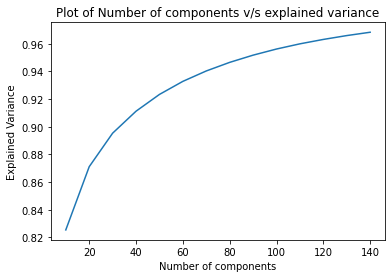

In [18]:
import matplotlib.pyplot as plt

plt.plot(n_comp, variance_sum)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [19]:
# choose 140 as final dimension to reduce to 
# 利用上述找到的最適合dimension來對co-occurrence matrix進行降維
svd = TruncatedSVD(n_components=140)
svd.fit(co_matrix)
re_co_matrix = svd.transform(co_matrix)

### 使用KNN模型進行分類
在進行分類之前，先利用簡單的詞向量平均來計算文本向量

[參考文獻](https://medium.com/ai-academy-taiwan/nlp-%E4%B8%8D%E5%90%8C%E8%A9%9E%E5%90%91%E9%87%8F%E5%9C%A8%E6%96%87%E6%9C%AC%E5%88%86%E9%A1%9E%E4%B8%8A%E7%9A%84%E8%A1%A8%E7%8F%BE%E8%88%87%E5%AF%A6%E4%BD%9C-e72a2daecfc)

In [20]:
# get doc vector via take mean of all word vectors inside the corresponding document

def make_doc_vectors(corpus: List[str], word2idx: dict, vocab_list: List) -> List[np.ndarray]:
    
    # vectorizing data 
    # and make document vector by take mean to all word vecto
    doc_vec = []
    empty_doc_list = []
    for i, sms_msg in enumerate(corpus):
        sms_msg = [word2idx[word] for word in sms_msg.split() if word in vocab_list] #tokenize
        if len(sms_msg) > 0:
            sms_msg = np.array([re_co_matrix[ids] for ids in sms_msg]) #vectorize
            doc_vec.append(sms_msg.mean(axis=0))
        else:
            empty_doc_list.append(i)
            print(f"document {i} doesn't contain word in vocab_list")
            print(corpus[i])
            print("\n")
        
    return np.vstack(doc_vec), empty_doc_list

word2idx = vectorizer.vocabulary_
vocab_list = vectorizer.get_feature_names()

doc_vec_train, missing_train_list = make_doc_vectors(x_train, word2idx, vocab_list)
print("="*50)
doc_vec_test, missing_test_list = make_doc_vectors(x_test, word2idx, vocab_list)


document 305 doesn't contain word in vocab_list



document 584 doesn't contain word in vocab_list
ringtoneking


document 929 doesn't contain word in vocab_list
raviyog peripherals bhayandar east


document 2035 doesn't contain word in vocab_list
ultimately tor motive tui achieve korli


document 2411 doesn't contain word in vocab_list
erutupalam thandiyachu


document 2627 doesn't contain word in vocab_list



document 2773 doesn't contain word in vocab_list
hanks lotsly


document 3048 doesn't contain word in vocab_list
u


document 3189 doesn't contain word in vocab_list
g w r


document 3241 doesn't contain word in vocab_list
east coast


document 3745 doesn't contain word in vocab_list
k k congratulation


document 4092 doesn't contain word in vocab_list
audrie lousy autocorrect


document 92 doesn't contain word in vocab_list
beerage


document 316 doesn't contain word in vocab_list
tf p


document 796 doesn't contain word in vocab_list
garbage bags eggs jam bread hannaford whea

In [21]:
from sklearn.neighbors import KNeighborsClassifier

# training
y_train_filter = np.delete(np.array(y_train), missing_train_list)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(doc_vec_train, y_train_filter)
train_pred = knn.predict(doc_vec_train)

# testing
y_test_filter = np.delete(np.array(y_test), missing_test_list)
test_pred = knn.predict(doc_vec_test)

In [22]:
print(f"train acc: {np.sum(train_pred == y_train_filter) / len(y_train_filter)}")
print(f"train acc: {np.sum(test_pred == y_test_filter) / len(y_test_filter)}")

train acc: 0.9716535433070866
train acc: 0.9567956795679567
